<a href="https://colab.research.google.com/github/educanto/keras_fashion_mnist/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install tensorflow==2.14.0 -q

In [84]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math

# **Some functions**

In [104]:
def plot_top_losses(loss_values, x_test, y_test, probs, k=9, figsize=(10,10)):
    top_k = loss_values.argsort()[-k:][::-1]
    print('top losses indexes: ', top_k)
    cols = math.ceil(math.sqrt(k))
    rows = math.ceil(k/cols)
    fig,axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14).set_position([.5, 1.05])
    i=0
    for index in top_k:
        image = x_test[index]
        actual = y_test[index]
        loss_value = loss_values[index]
        predicted = np.argmax(probs[index])
        prob = probs[index][predicted]
        title = f'{labels[predicted]}/{labels[actual]}/{loss_value:.2f}/{prob:.2f}'
        ax = axes.flat[i]
        i+=1
        image = np.squeeze(image)
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
    fig.tight_layout()

**Callback to save the best model**

In [86]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()
        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

# **Load dataset**

In [87]:
((x_train, y_train), (x_test, y_test)) = tf.keras.datasets.fashion_mnist.load_data()

labels = {
    0: 'T-shirt_top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# **Checking dataset**

In [88]:
print(x_train.shape)
print(x_test.shape)

print(y_train.min())
print(y_train.max())

(60000, 28, 28)
(10000, 28, 28)
0
9


# **Show some data**

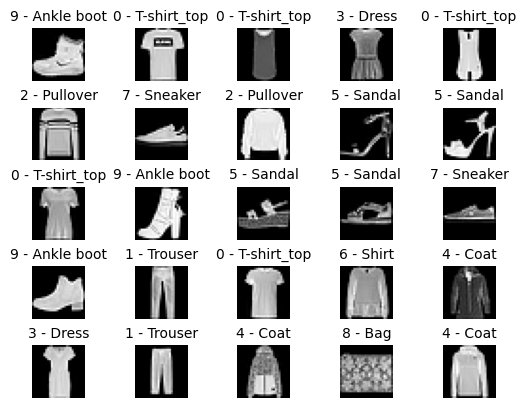

In [89]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(f"{y_train[i]} - {labels[y_train[i]]}", fontsize=10)
    plt.axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

# **Normalize images**

In [90]:
x_train_norm = x_train/float(255)
x_test_norm = x_test/float(255)

# **Create and compile model**

In [91]:
def create_model():
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))

    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(maxpool1)
    maxpool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    flatten = tf.keras.layers.Flatten()(maxpool2)

    dropout = tf.keras.layers.Dropout(0.1)

    output_layer = tf.keras.layers.Dense(len(labels), activation='softmax')(flatten)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    return model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 800)               0   

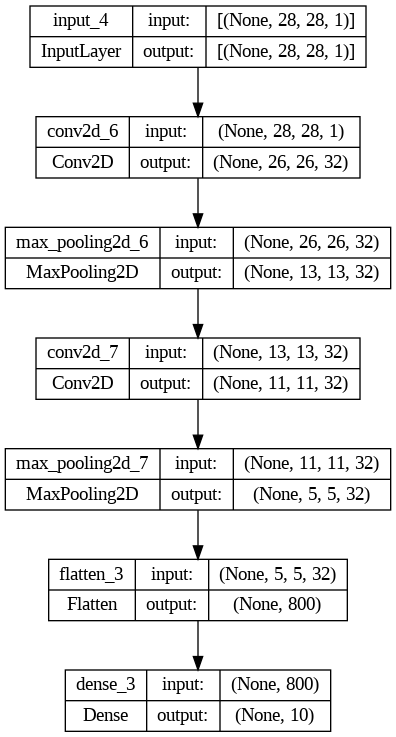

In [92]:
model = create_model()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-04)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

save_best_model = SaveBestModel()
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
            save_best_model]

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# **Train model**

In [93]:
history = model.fit(x_train_norm, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/30
1500/1500 [==============================] - 11s 6ms/step - loss: 0.6262 - accuracy: 0.7774 - val_loss: 0.4461 - val_accuracy: 0.8423
Epoch 2/30
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4208 - accuracy: 0.8507 - val_loss: 0.4012 - val_accuracy: 0.8580
Epoch 3/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3767 - accuracy: 0.8668 - val_loss: 0.3809 - val_accuracy: 0.8677
Epoch 4/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3496 - accuracy: 0.8761 - val_loss: 0.3491 - val_accuracy: 0.8778
Epoch 5/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3279 - accuracy: 0.8828 - val_loss: 0.3430 - val_accuracy: 0.8788
Epoch 6/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3123 - accuracy: 0.8883 - val_loss: 0.3512 - val_accuracy: 0.8734
Epoch 7/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2973 - accuracy: 0.8933 - val_loss: 0.3114 - val_accurac

**Get weigths from the best model (optional)**

In [94]:
print(save_best_model.best)
model.set_weights(save_best_model.best_weights)

0.2665072977542877


# **Results**

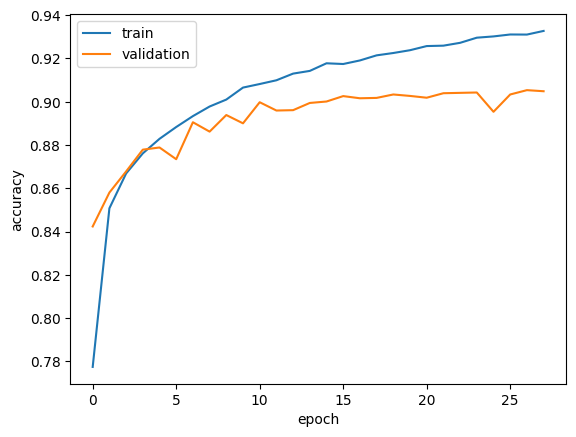

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

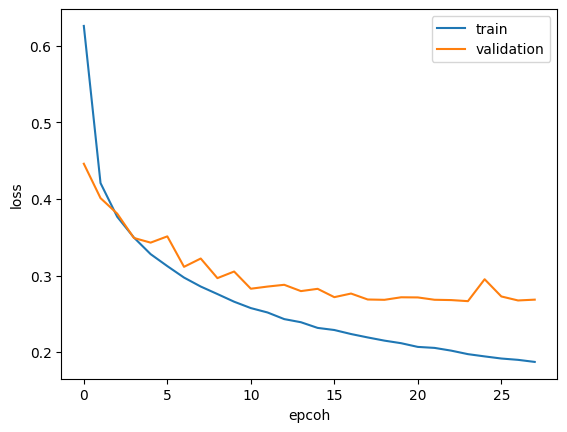

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epcoh')
plt.ylabel('loss')
plt.legend(['train', 'validation'])

# **Evaluating the model**

In [97]:
test_loss, acc_test = model.evaluate(x_test_norm, y_test)
print('test loss:', test_loss)
print('test accuracy:', acc_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2798 - accuracy: 0.8975
test loss: 0.2798178791999817
test accuracy: 0.8974999785423279


# **Plotting top losses**

In [98]:
probs = model.predict(x_test_norm)
loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
loss_values = loss(y_test, probs).numpy()
print(loss_values)

313/313 [==============================] - 1s 2ms/step
[2.7640813e-04 6.0901782e-03 1.0728830e-06 ... 5.7338024e-05 3.6477377e-05
 1.3423964e-01]


top losses indexes:  [5512  787 6331 4693 1111 6485 4392   23 3531 3489 5569 2001 1300 5533
 2914 4041]


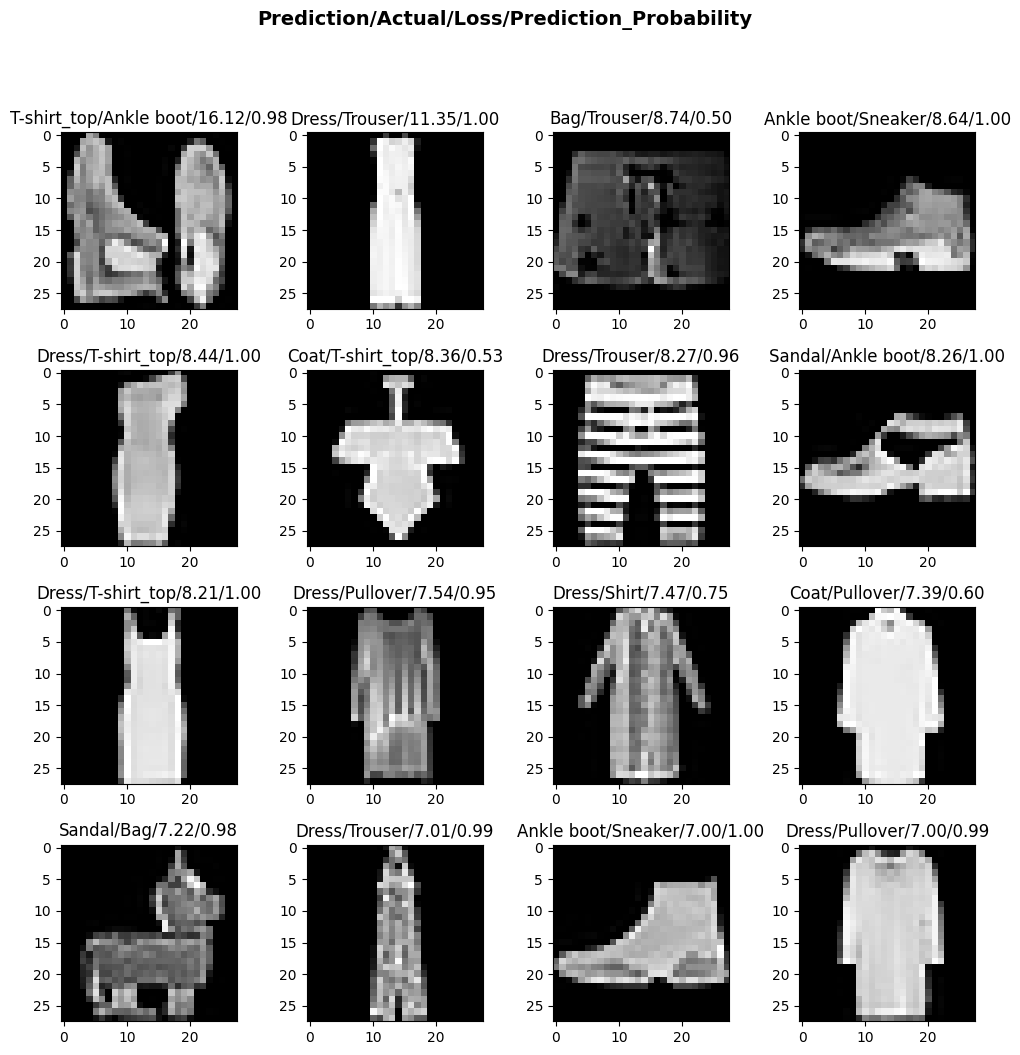

In [99]:
plot_top_losses(loss_values, x_test, y_test, probs, k=16)

# **Save model**

In [100]:
model.save('exported_model')

# **Testing loaded model**

In [101]:
loaded_model = tf.keras.models.load_model('exported_model')
loaded_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 800)               0   

In [102]:
test_pred = loaded_model.predict(x_test_norm)
print('test result:      ', np.argmax(test_pred, axis=1)[0:20])
print('test image number:', y_test[0:20])

313/313 [==============================] - 1s 2ms/step
test result:       [9 2 1 1 6 1 4 6 5 7 4 5 8 3 4 1 2 2 8 0]
test image number: [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0]
